# Event frequency
## Get the data


In [1]:
# builds the connection to azure:
%matplotlib inline

import os
import sys

import numpy as np

import seaborn as sns

# import custom modules:
module_path = os.path.dirname(os.path.abspath(''))
if module_path not in sys.path:
    sys.path.append(module_path)
from common.get_data import *

#set colour palette for seaborn
colors = set_colours()
sns.set_palette(sns.color_palette(colors))
#get engine for sql queries
engine=get_engine()


In [2]:
# get model_version
model_version = pd.read_sql_query('''select value from model_metadata where item = 'model_version' ''', engine)
model_version = model_version.iloc[0][0]
model_version

'v2022.2.3'

## Get model data

In [3]:
# get model_data
df_model = pd.read_sql_query('''
    select
        run_id::text as entity,
        'model' as source,
        'model' as year,
        confidentiality,
        integrity,
        availability,
        extortion
    from
        model_events
''', engine)
df_model.tail()

,entity,source,year,confidentiality,integrity,availability,extortion
5694063,modelchangesflow-fortune-0295-v2022.2.3-2022-0...,model,model,1,0,1,0
5694064,modelchangesflow-fortune-0295-v2022.2.3-2022-0...,model,model,1,0,1,0
5694065,modelchangesflow-fortune-0295-v2022.2.3-2022-0...,model,model,1,0,1,0
5694066,modelchangesflow-fortune-0295-v2022.2.3-2022-0...,model,model,1,0,1,0
5694067,modelchangesflow-fortune-0295-v2022.2.3-2022-0...,model,model,1,0,1,0


In [4]:
df_model['frequency'] = 1/10000/1000
df_model['frequency'].sum()

0.569406800000007

## Get Events data


In [5]:
event_cols = [
    'event_id',  
    'event_start_date',
    'impact_type_availability',
    'impact_type_confidentiality',
    'impact_type_extortion', 
    'impact_type_integrity',]
df_events = read_f1k_table()[event_cols]

df_events.rename({
    'event_id':'',  
    'impact_type_availability':'availability',
    'impact_type_confidentiality':'confidentiality',
    'impact_type_extortion':'extortion', 
    'impact_type_integrity':'integrity',
    }, axis='columns', inplace=True)
df_events.head()

# adjust columns
df_events['year'] = df_events['event_start_date'].dt.year
count_of_years = len(df_events['year'].unique())
df_events['frequency'] = 1/count_of_years/1000
df_events['source']='events'


## Combine Data

In [6]:
df_comb = pd.concat([df_events[['availability', 'confidentiality', 'extortion', 'integrity', 'year', 'frequency','source',]],
                     df_model[['availability', 'confidentiality', 'extortion', 'integrity', 'year', 'frequency','source',]]]).reset_index()

In [7]:
df_comb['availability'] = df_comb['availability'].astype(bool)
df_comb['confidentiality'] = df_comb['confidentiality'].astype(bool)
df_comb['extortion'] = df_comb['extortion'].astype(bool)
df_comb['integrity'] = df_comb['integrity'].astype(bool)

## Compare overall frequency

In [8]:
df_plot = df_comb.groupby(['confidentiality','source']).agg({'frequency':'sum'}).reset_index()
#df_plot['confidentiality'] = df_plot['confidentiality'].astype(str)
#df_plot['x_axis'] = df_plot['source'] + df_plot['confidentiality']
df_plot

,confidentiality,source,frequency
0,False,events,0.018364
1,False,model,0.269296
2,True,events,0.318636
3,True,model,0.300111


<AxesSubplot:xlabel='source', ylabel='frequency'>

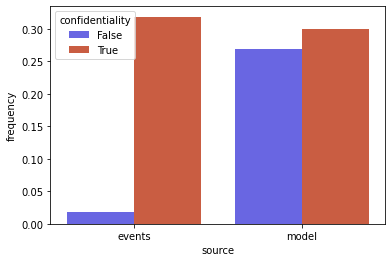

In [9]:
sns.barplot(data=df_plot, x='source', y=df_plot['frequency'], hue='confidentiality')

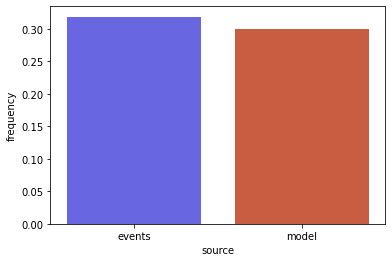

In [10]:
ax = sns.barplot(data=df_plot.loc[df_plot['confidentiality']==True], x='source', y=df_plot['frequency'])


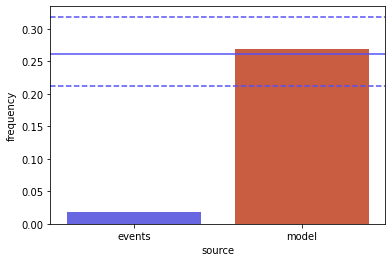

In [16]:
ax = sns.barplot(data=df_plot.loc[df_plot['confidentiality']==False], x='source', y=df_plot['frequency'])

event_confidentiality_frequency = df_plot.loc[(df_plot['confidentiality']==True) & (df_plot['source']=='events'), 'frequency'].values[0]

#bands estimated from the Verizon 2022 DBIR report p18
event_breach_freq_high = event_confidentiality_frequency/0.50 - event_confidentiality_frequency
event_breach_freq_mid = event_confidentiality_frequency/0.55 - event_confidentiality_frequency
event_breach_freq_low = event_confidentiality_frequency/0.60- event_confidentiality_frequency


ax.axhline(event_breach_freq_high, ls='--')
ax.axhline(event_breach_freq_mid)
ax.axhline(event_breach_freq_low, ls='--')